In [ ]:
!pip install transformers torch pandas scikit-learn -q

In [ ]:
!pip install -U transformers -q

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
import torch
import pandas as pd

print(" Loading dataset...")
#df = pd.read_csv("complaints.csv")
df = pd.read_csv("complaints.csv", on_bad_lines='skip', engine='python')

df = df.dropna(subset=["Consumer complaint narrative"])


df = df.sample(19000, random_state=42)
print(f"Dataset shape after sampling: {df.shape}")

categories = [
    'Mortgage',
    'Checking or savings account',
    'Credit reporting, credit repair services, or other personal consumer reports',
    'Vehicle loan or lease',
    'Debt collection',
    'Credit card',
    'Money transfer, virtual currency, or money service',
    'Credit card or prepaid card',
    'Student loan',
    'Payday loan, title loan, personal loan, or advance loan',
    'Debt or credit management',
    'Payday loan, title loan, or personal loan'
]

df = df[df["Product"].isin(categories)]
print(f" Filtered dataset shape: {df.shape}")

# Split into train, validation, and test sets (80/10/10)
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df["Consumer complaint narrative"].tolist(),
    df["Product"].tolist(),
    test_size=0.2,  # 20% for validation+test
    random_state=42
)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts,
    temp_labels,
    test_size=0.5,  # Split 20% into 10% val + 10% test
    random_state=42
)

print(f"Train size: {len(train_texts)}, Validation size: {len(val_texts)}, Test size: {len(test_texts)}")


print(" Loading FinBERT...")
tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained(
    "ProsusAI/finbert",
    num_labels=len(categories),
    ignore_mismatched_sizes=True
)


print(" Tokenizing complaint text...")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=64)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=64)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=64)

label2id = {label: idx for idx, label in enumerate(categories)}
id2label = {idx: label for label, idx in label2id.items()}
train_labels = [label2id[label] for label in train_labels]
val_labels = [label2id[label] for label in val_labels]
test_labels = [label2id[label] for label in test_labels]

class ComplaintDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.labels)

train_dataset = ComplaintDataset(train_encodings, train_labels)
val_dataset = ComplaintDataset(val_encodings, val_labels)
test_dataset=ComplaintDataset(test_encodings, test_labels)


training_args = TrainingArguments(
    output_dir="./results",
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


trainer.train()

print("Evaluating model...")
results = trainer.evaluate()
print("Evaluation Results:", results)

print(" Saving model...")
trainer.save_model("./finbert_complaint_model")
print("Model saved successfully!")



 Loading dataset...
Dataset shape after sampling: (19000, 18)
 Filtered dataset shape: (19000, 18)
Train size: 15200, Validation size: 1900, Test size: 1900
 Loading FinBERT...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ProsusAI/finbert and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([12]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Tokenizing complaint text...


Step,Training Loss
10,2.587800
20,2.290800
30,2.250000
40,2.097200
50,1.894000
60,1.869600
70,1.917100
80,1.789800
90,1.966200
100,1.723200


Evaluating model...


Evaluation Results: {'eval_loss': 0.7360419034957886, 'eval_runtime': 6.4396, 'eval_samples_per_second': 295.047, 'eval_steps_per_second': 36.959, 'epoch': 1.0}
 Saving model...
Model saved successfully!


In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = "I was charged twice on my credit card and the bank refused to refund."

# Tokenize and move input to GPU
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

# Run inference (no gradient tracking for speed)
with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])


Using device: cuda

Predicted Category: Credit card


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = "Debt Collector failed to identify themselves as a Debt Colletor - represented themselves as an attorney. Threatened law suits and seizure of banks/property. "

inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\n🔮 Predicted Category:", id2label[pred_label])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = "I am filing a complaint against Cash App ( Block , Inc. ) due to inadequate customer service and unfair practices, which violate the Consumer Financial Protection Act ( CFPA ). Specifically, Cash App failed to take timely and effective measures to prevent and address fraud on their platform, leaving my account vulnerable and unprotected. Furthermore, their dispute resolution process was unfair and deceptive, as they did not comply with error resolution requirements under the Electronic Fund Transfer Act ( EFTA ) and Regulation E. These actions have caused significant inconvenience and financial loss, and I seek appropriate redress for these violations."

inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = "I am writing to formally express my concerns regarding Zelle 's handling of disputes, particularly in light of the recent CFPB lawsuit highlighting significant issues with the platform. Despite using Zelle numerous times and reporting discrepancies, my financial institution and Zelle failed to investigate my claims adequately. They informed me that recovering lost funds was impossible and that tracking these transactions was unfeasible. The CFPB 's findings indicate that Zelle has not only neglected to protect consumers but has also allowed repeat offenders to exploit the system, leaving users vulnerable to scams. This lack of accountability and transparency is unacceptable and raises serious concerns about consumer safety."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = "Hi, I believe I am a victim of a Predatory Loan and Auto Fraud. In 2018 I was pressured into a car sale with Santander Consumer as the loan company at XXXX XXXX XXXX dealership in XXXX XXXX. I believe they used fraud tactics to get me approved as I did not qualify or make enough to pay for the car properly. I already had an older Vehicle through a partnered dealersip for much less and was pressured to upgrade and trade in my car through the bigger and better dealership. They pressured me into a co signer in which they used my father who credit or income wasnt much better than mine. I believe they mixed and matched our information in order to get me approved. The Co borrower and Borrower are different on the dealership forms and the loan forms on one i am the co borrower XXXX XXXX and on the other my father who is now deceased is the co borrower XXXX XXXX XXXX. The attachments below will show the the differences and all the unfair intrest that was applied. This company had a class action lawsuit that I should have been apart of considering I met all requirements but I was never contacted. I would like to receive full compensation for all payments made and or have the vehicle payments ended and car title released to me as the owner. Lastly I also believe im intilted to compensation because santander had my car repossed in a breached peace manner multilple times in which I had to pay thousands of dollars to get my car back. Please help this is not lawful consumer business"
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = '''I began making payments on my loans in XX/XX/XXXX, as I graduated college in XXXX XXXX  XXXX. My first payment was made XX/XX/XXXX for two months of payments because MOHELA was not allowing my first payment to go through. The payment made on XX/XX/XXXX was for {$570.00} according to my bank statement. The payment is titled ELECTRONIC PMT-WEB, XXXX XXXX  XXXX XXXX XXXX. My second payment was made XX/XX/XXXX, for {$280.00}. The payment is titled ACH DEBIT, XXXX XXXX XXXXXXXX XXXX XXXX.

According to MOHELA and Studentaid.gov they only show records of payments starting XX/XX/XXXX, on XX/XX/XXXX. They only show records of 4 months of payments starting in XXXX and do not show the two payments of {$570.00} and {$280.00} made XX/XX/XXXX and XX/XX/XXXX respectively. Both websites show that I have paid {$1100.00} in total, while my bank statements show that I have made payments totaling {$2000.00}.

I have submitted a complaint on studentaid.gov, and have reached out to MOHELA who explained it could take up to two months for my original payments to show on the new platform they started using in XXXX.'''
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = "Chime is the company they're backed by stride bank I believe and they took my money. {$500.00} then locked my account and they won't let me back into it I've tried to call in at least 20 times. I've received no reply from anybody at chime. Only automated confirmation or emails"
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = '''Patenaude and Felix APC Isa debt collector for XXXX XXXX. During the pandemic my account went to collections. My wife and I had a joint account. Patenaude and Felix sent garnishment letters from XXXX to XXXX. They began my wages weekly in XX/XX/XXXX. My wife contacted them to resolve her issue or put blame me. My wife and I are separated and not speaking with each other. Patenaude and Felix APC sent legal documents to my payroll department at the XXXX XXXX XXXX in XX/XX/XXXX. My name is the only name mentioned on a joint account with my wife XXXX XXXX. ( Credit card ending XXXX ) The garnishment is weekly between {$99.00} to {$110.00}. My wages at the is XXXX hourly. What Justice would approve garnishment of my wages? I think it maybe a scam. The garnishment totals $ XXXX monthly. There's many scammer 's out there. My apartment complex make fraudulent charges too.

*Please cancel my current complaint XXXX. It was entered incorrectly. My apologies.'''
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = '''I began making payments on my loans in XX/XX/XXXX, as I graduated college in XXXX XXXX  XXXX. My first payment was made XX/XX/XXXX for two months of payments because MOHELA was not allowing my first payment to go through. The payment made on XX/XX/XXXX was for {$570.00} according to my bank statement. The payment is titled ELECTRONIC PMT-WEB, XXXX XXXX  XXXX XXXX XXXX. My second payment was made XX/XX/XXXX, for {$280.00}. The payment is titled ACH DEBIT, XXXX XXXX XXXXXXXX XXXX XXXX.

According to MOHELA and Studentaid.gov they only show records of payments starting XX/XX/XXXX, on XX/XX/XXXX. They only show records of 4 months of payments starting in XXXX and do not show the two payments of {$570.00} and {$280.00} made XX/XX/XXXX and XX/XX/XXXX respectively. Both websites show that I have paid {$1100.00} in total, while my bank statements show that I have made payments totaling {$2000.00}.

I have submitted a complaint on studentaid.gov, and have reached out to MOHELA who explained it could take up to two months for my original payments to show on the new platform they started using in XXXX.'''
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])


In [ ]:
df['Product'].unique()

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()

test_text = "Debt collector is pusuing a debt that over XXXX  years. the adress they provide is when i was in college in XXXX their unable to provide any iformation as far as my SS security number or account number. In addition, they mention the debt if from XXXX which is the telephone company ive been with for over XXXX  years and still currently with XXXX. I contacted XXXX and assure that this debt is not from them which I already knew. if I HAD A BALANCE WITH XXXX I THINK THEY WOULD MENTION IT TO ME AND NOT A DEBT COLLECTOR THIS IS A SCAM. the debt collector company is XXXX XXXX XXXX FOR {$190.00} AND IT WAS OPEN XX/XX/year>XXXX XXXX"
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])


In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="I recognize that under FCRA 605B, it's crucial to eliminate any erroneous accounts from my credit report. Would you kindly review the documents? I've observed that a significant number of the listed accounts appear to be incorrect, and this is troubling to me."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="Incorrect credit report shows unpaid debt."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="They increased my monthly mortgage payment without giving any prior notice."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="I deposited a check last week, but the money hasn’t been credited to my account yet."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="I’ve been trying to get details about my escrow balance, but customer service keeps ignoring my requests."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="A withdrawal I didn’t authorize appeared yesterday, and the bank hasn’t reversed it yet."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="I disputed an incorrect payment entry, but it still appears on my report as unpaid."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="I keep getting calls from a third party claiming I owe money that I’ve already cleared."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="The transaction was declined even though there was enough limit available."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="I sent money to a relative overseas, but the transfer never went through and my balance decreased."
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


model.to(device)
model.eval()
test_text="I applied for a payment reduction program months ago, but no one has updated me since.”"
inputs = tokenizer(
    test_text,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=64
).to(device)

with torch.no_grad():
    outputs = model(**inputs)
    pred_label = torch.argmax(outputs.logits, dim=1).item()

print("\nPredicted Category:", id2label[pred_label])



In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

tokenizer.save_pretrained("/content/drive/MyDrive/finbert_complaint_model")

print(" Tokenizer saved successfully! Folder now ready for loading.")


In [ ]:
!pip install gradio transformers torch pandas -q
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch, pandas as pd, gradio as gr

model_path = "/content/drive/MyDrive/finbert_complaint_model"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

id2label = {
    0: 'Mortgage',
    1: 'Checking or Savings Account',
    2: 'Credit Reporting or Repair Services',
    3: 'Vehicle Loan or Lease',
    4: 'Debt Collection',
    5: 'Credit Card',
    6: 'Money Transfer or Virtual Currency',
    7: 'Prepaid or Credit Card',
    8: 'Student Loan',
    9: 'Personal or Payday Loan',
    10: 'Debt or Credit Management'
}

def classify_complaint(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()
    return id2label[pred]

demo = gr.Interface(
    fn=classify_complaint,
    inputs=gr.Textbox(lines=4, placeholder="Paste customer complaint..."),
    outputs="text",
    title="🏦 FinBERT Banking Complaint Classifier",
    description="Fine-tuned FinBERT model classifies complaints into banking product categories."
)
demo.launch(share=True)


In [ ]:
import os
print(os.listdir("/content/drive/MyDrive/finbert_complaint_model"))

Generating predictions on validation set...



✅ Validation Accuracy: 0.7663

📊 Classification Report:
                                                                              precision    recall  f1-score   support

                                                                    Mortgage       0.81      0.88      0.84       139
                                                 Checking or savings account       0.72      0.82      0.77       332
Credit reporting, credit repair services, or other personal consumer reports       0.00      0.00      0.00         6
                                                       Vehicle loan or lease       0.75      0.69      0.72        77
                                                             Debt collection       0.85      0.90      0.87       606
                                                                 Credit card       0.57      0.75      0.65       251
                          Money transfer, virtual currency, or money service       0.89      0.82      0.86       23

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


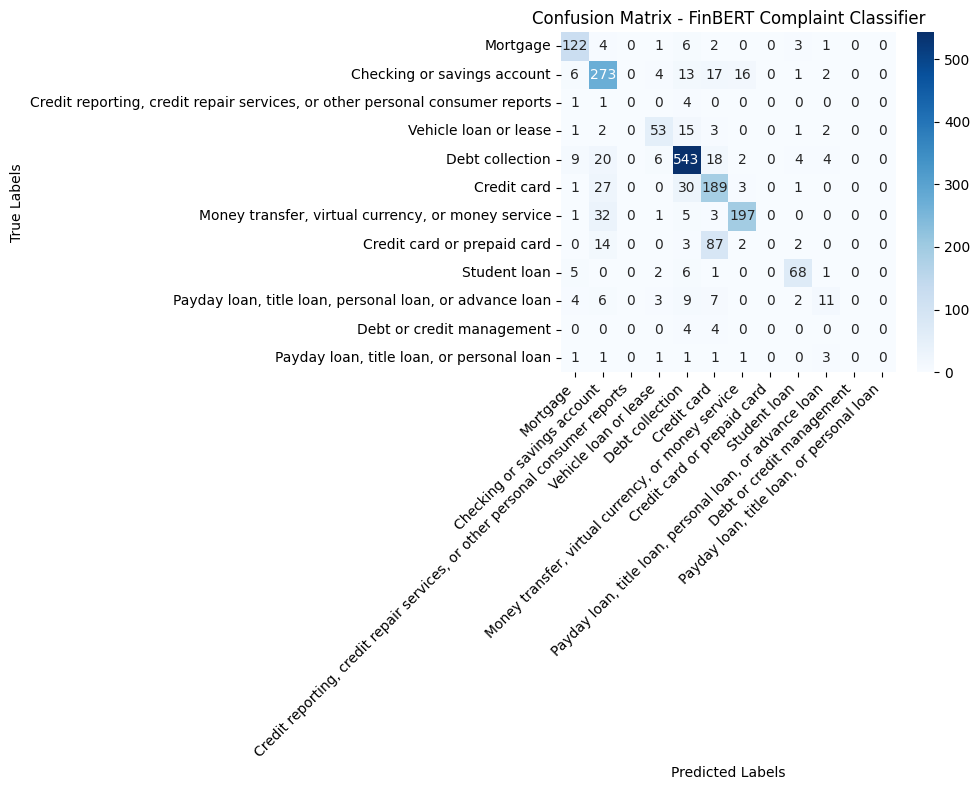

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Get predictions from the trained model
print("Generating predictions on validation set...")

predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# 2️⃣ Compute accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Validation Accuracy: {acc:.4f}")

# 3️⃣ Print detailed classification report
print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=list(id2label.values())))

# 4️⃣ Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 5️⃣ Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(id2label.values()),
    yticklabels=list(id2label.values())
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - FinBERT Complaint Classifier')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Generating predictions on test set...



✅ Test Accuracy: 0.7563

📊 Classification Report:
                                                                              precision    recall  f1-score   support

                                                                    Mortgage       0.73      0.75      0.74       114
                                                 Checking or savings account       0.74      0.83      0.78       322
Credit reporting, credit repair services, or other personal consumer reports       0.00      0.00      0.00         9
                                                       Vehicle loan or lease       0.81      0.61      0.70        75
                                                             Debt collection       0.82      0.91      0.86       614
                                                                 Credit card       0.59      0.71      0.64       264
                          Money transfer, virtual currency, or money service       0.85      0.82      0.84       264
    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


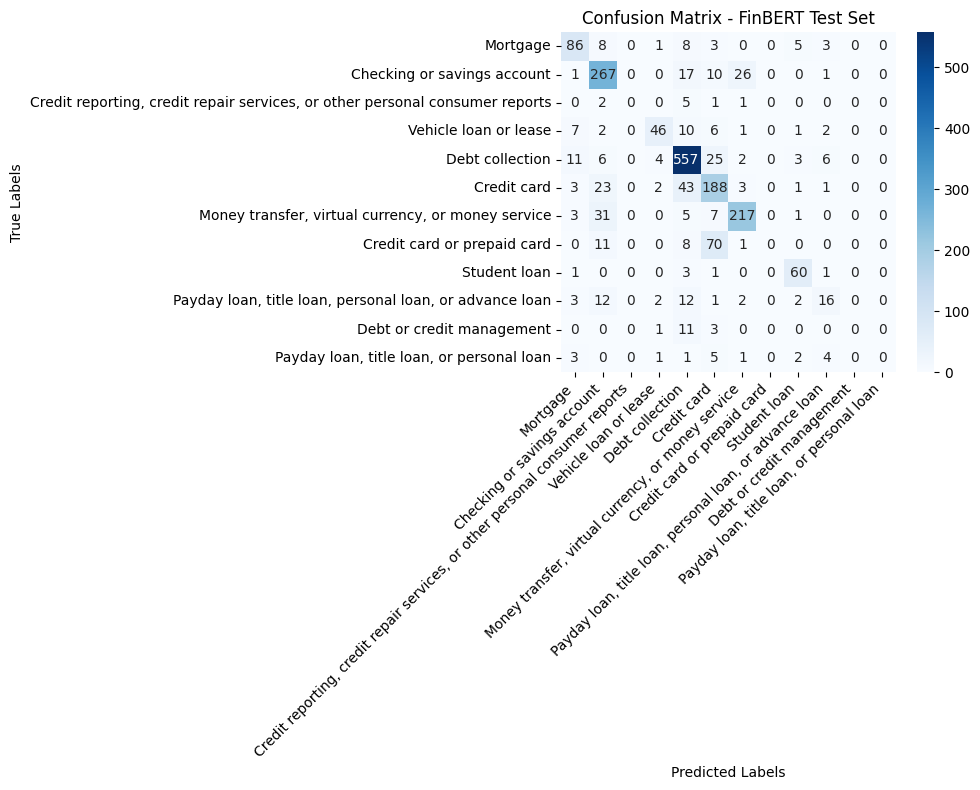

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1️⃣ Get predictions from the trained model
print("Generating predictions on test set...")

predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

# 2️⃣ Compute accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")

# 3️⃣ Print detailed classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=list(id2label.values())))

# 4️⃣ Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# 5️⃣ Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=list(id2label.values()),
    yticklabels=list(id2label.values())
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - FinBERT Test Set')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
